In [ ]:
import os
import shutil
import numpy as np

_DRIVE_ABS_PATH = "/content/drive/MyDrive"
_TRN_PATH = os.path.join(_DRIVE_ABS_PATH, "Training Slices")
DIR_PATH = os.path.join(_DRIVE_ABS_PATH, "Vehicle training data")
#os.mkdir(DIR_PATH)

paths = os.listdir(_TRN_PATH)
rand_values = np.random.choice(paths, 100)

for val in rand_values:
  shutil.copy2(os.path.join(_TRN_PATH, val), os.path.join('/content/drive/MyDrive/Vehicle training data', val))

In [1]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd /content/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 7098, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 7098 (delta 117), reused 150 (delta 83), pack-reused 6894
Receiving objects: 100% (7098/7098), 9.12 MiB | 27.23 MiB/s, done.
Resolving deltas: 100% (4853/4853), done.
/content/yolov5


In [2]:
!pip install -qr requirements.txt
import torch

from IPython.display import Image, clear_output
from utils.google_utils import gdrive_download

     |████████████████████████████████| 645kB 8.1MB/s 


In [ ]:
# Vehicles - !curl -L "https://app.roboflow.com/ds/fmJQuN8piH?key=MlOJUWUWzw" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
# Parking lots dataset #1 - !curl -L "https://app.roboflow.com/ds/R6lNGQVqOI?key=rFqwaGqtpy" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
!curl -L "https://app.roboflow.com/ds/uGrBvQG54Q?key=pUOxdpxWDu" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [ ]:
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
%cat /content/yolov5/models/yolov5s.yaml

In [ ]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
%cd /content/yolov5

/content/yolov5


In [ ]:
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 400 --data './data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-184-g3133607 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=16, bbox_interval=-1, bucket='', cache_images=True, cfg='./models/custom_yolov5s.yaml', data='./data.yaml', device='', entity=None, epochs=400, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='yolov5s_results', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov5s_results3', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=16, upload_dataset=False, weights='', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
2021-06-13 10:27:42.650167: I tensorflow/stream_executor/platf

In [ ]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results3/weights/best.pt --img 416 --conf 0.3 --source ./test/images

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.3, device='', exist_ok=False, half=False, hide_conf=False, hide_labels=False, imgsz=416, iou_thres=0.45, line_thickness=3, max_det=1000, name='exp', nosave=False, project='runs/detect', save_conf=False, save_crop=False, save_txt=False, source='./test/images', update=False, view_img=False, weights=['runs/train/yolov5s_results3/weights/best.pt'])
YOLOv5 🚀 v5.0-184-g3133607 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients, 16.8 GFLOPs
image 1/19 /content/yolov5/test/images/13scu35193893_1664_6240_png.rf.394a7bf67564f4909a34281be5d62ee6.jpg: 416x416 1 Parking Lot, Done. (0.011s)
image 2/19 /content/yolov5/test/images/13scu35303886_0_832_png.rf.3d3ee9d338c811319bda9b1246d646f4.jpg: 416x416 4 Parking Lots, Done. (0.010s)
image 3/19 /content/yolov5/test/images/13scu35393885_0_832_png.rf.8eb5fccbb037e229c389e6fa95992e99.jpg: 416x41

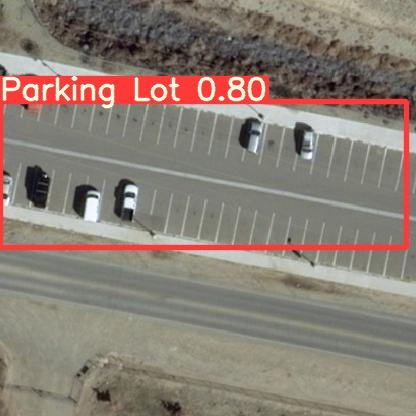

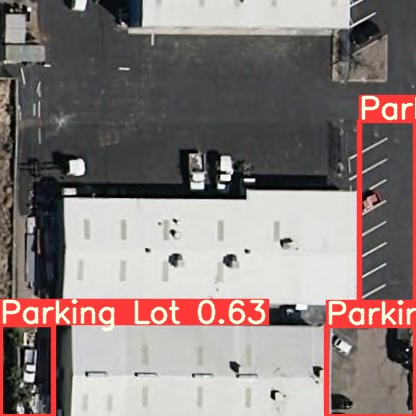

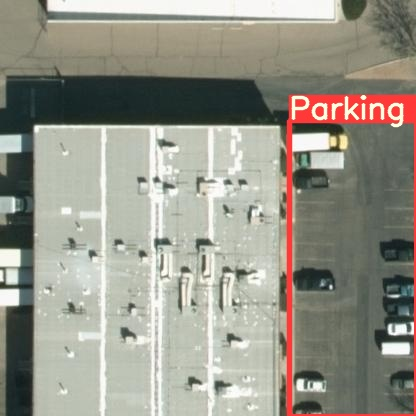

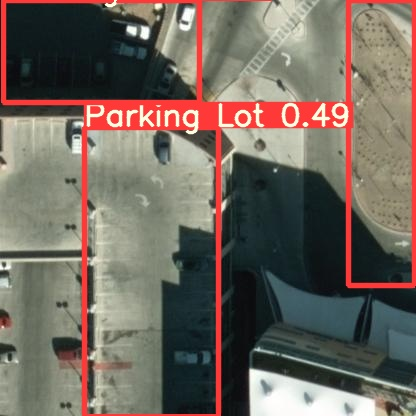

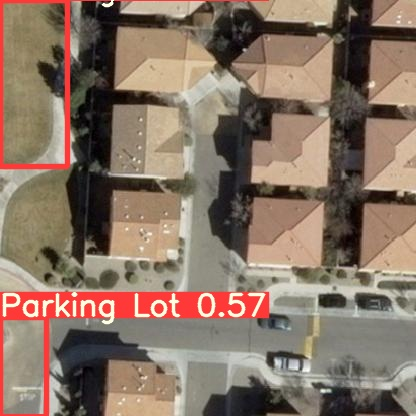

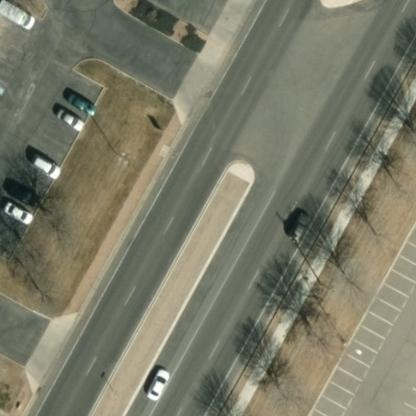

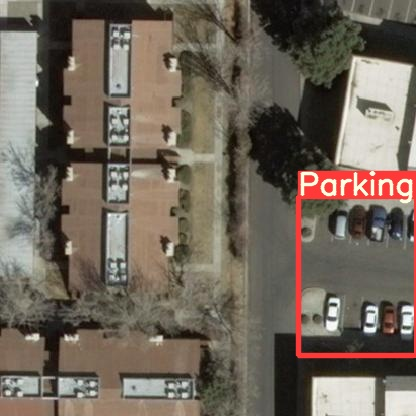

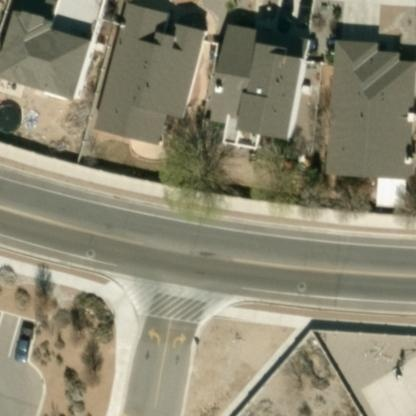

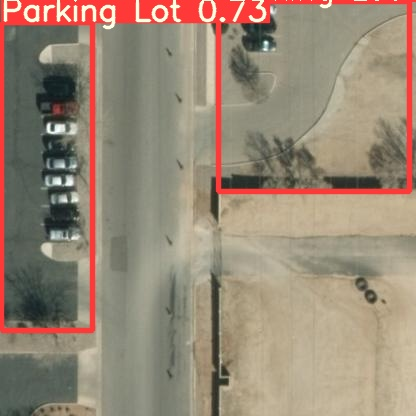

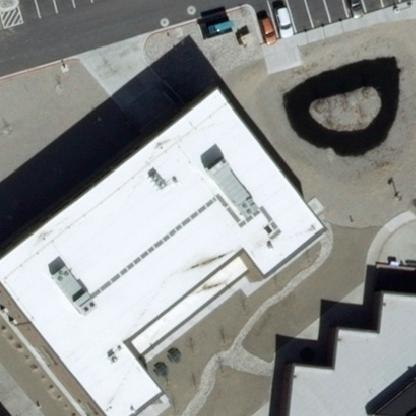

In [ ]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.jpg'):
    display(Image(filename=imageName))
    print("\n")

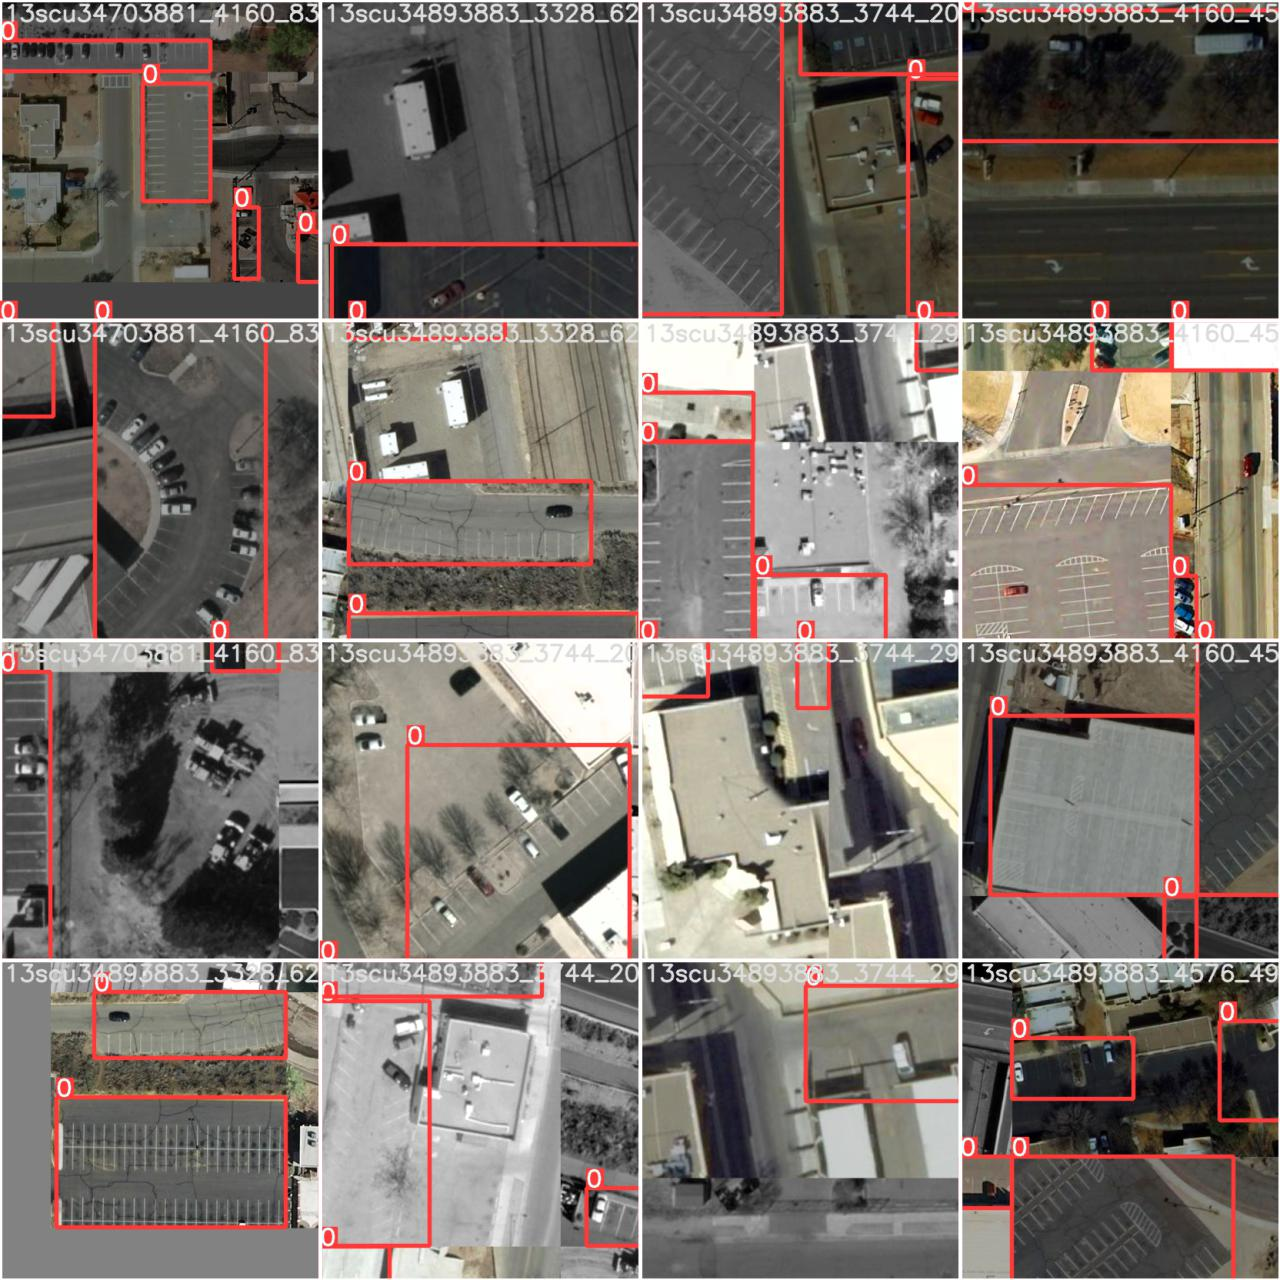

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5s_results2/train_batch0.jpg', width=900)

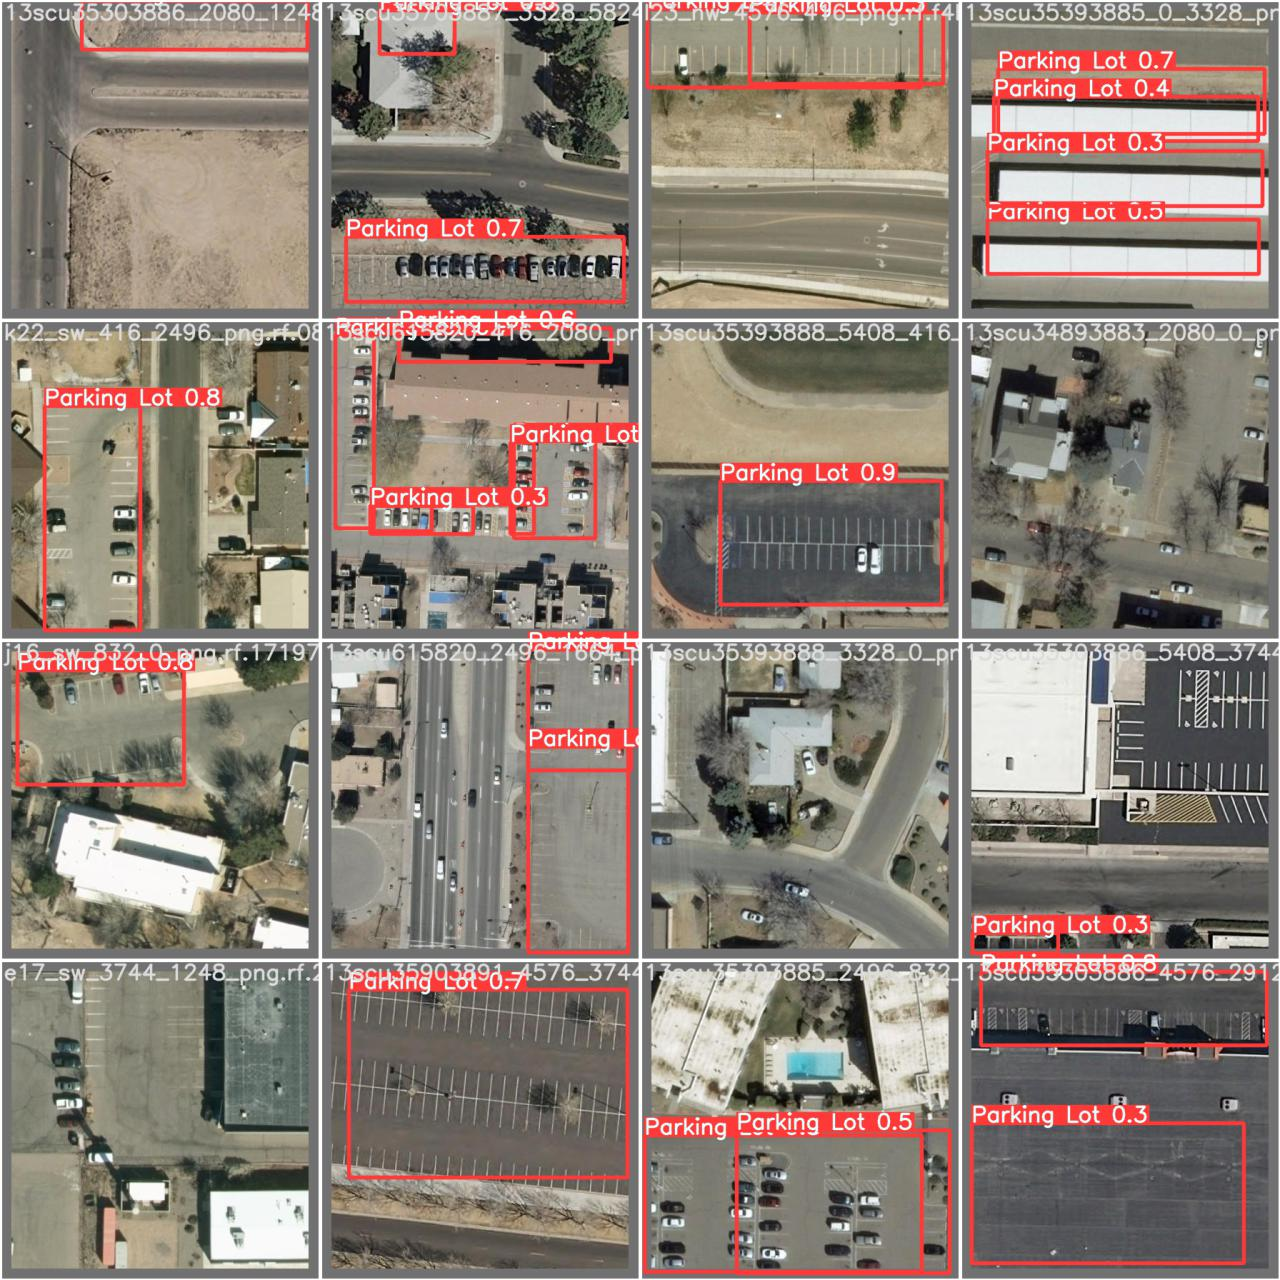

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5s_results2/test_batch0_pred.jpg', width=900)

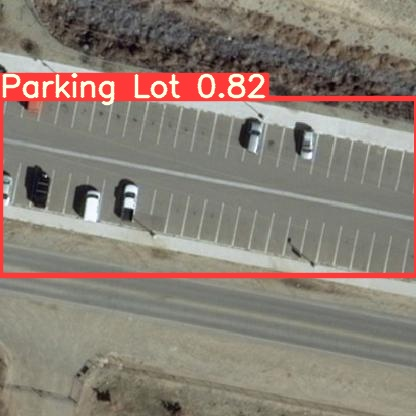

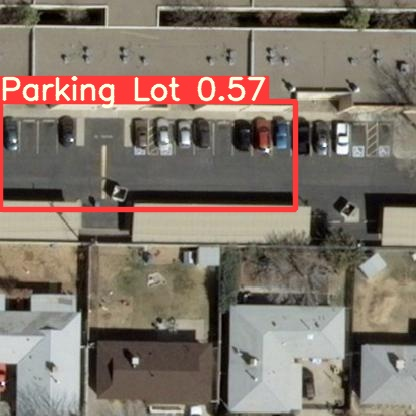

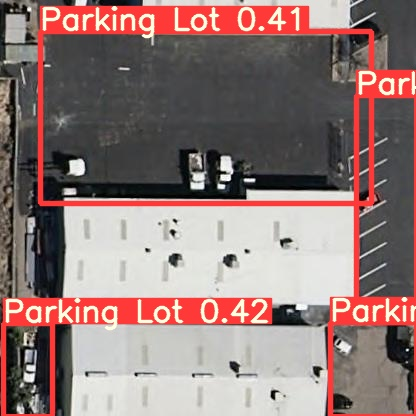

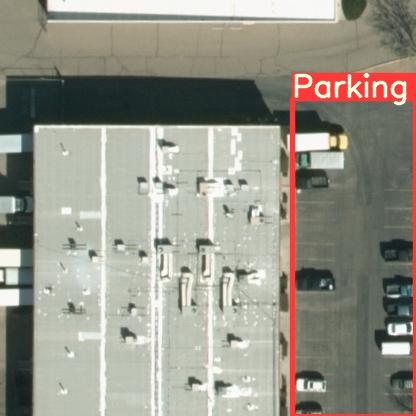

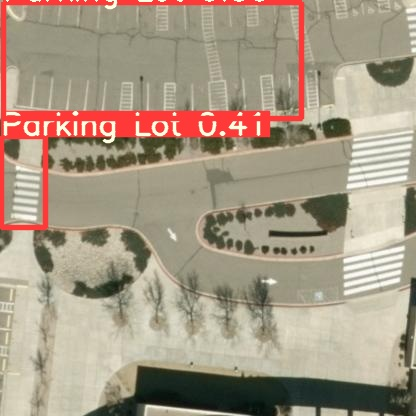

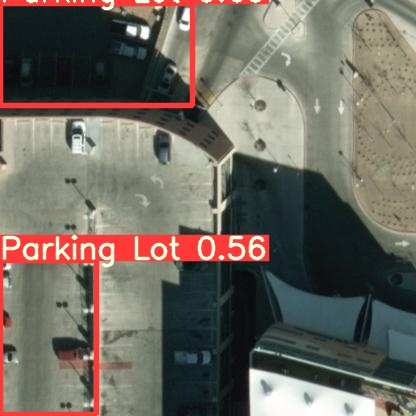

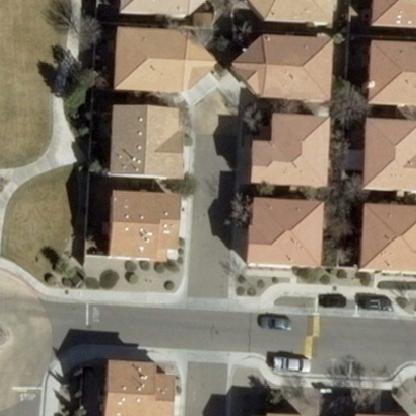

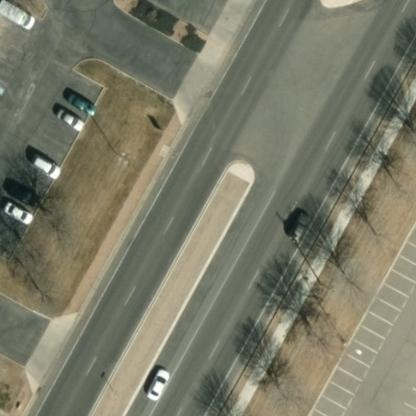

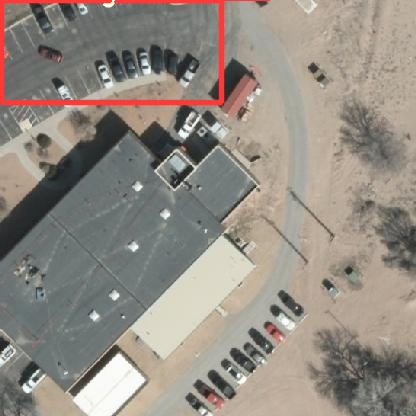

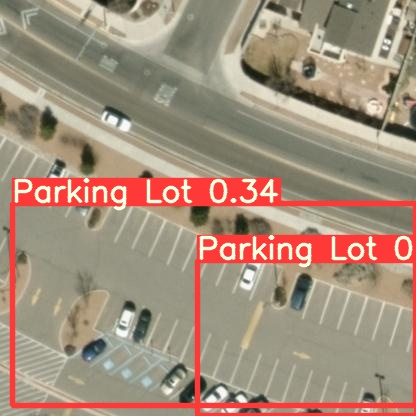

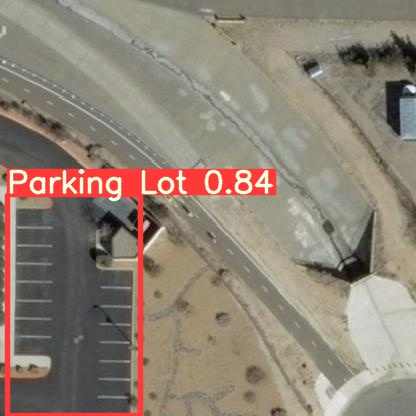

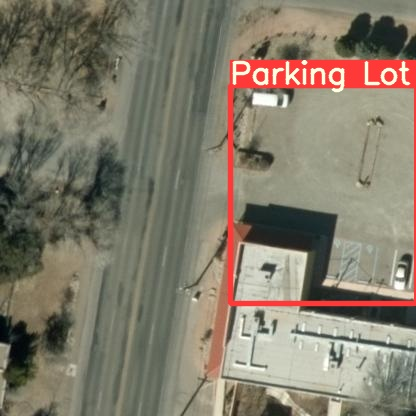

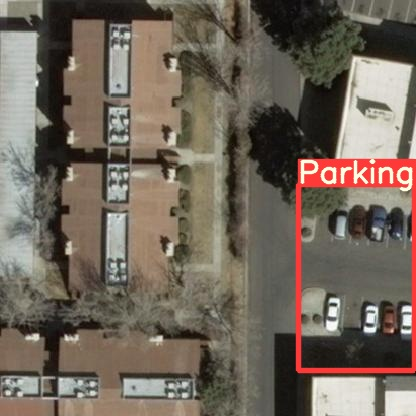

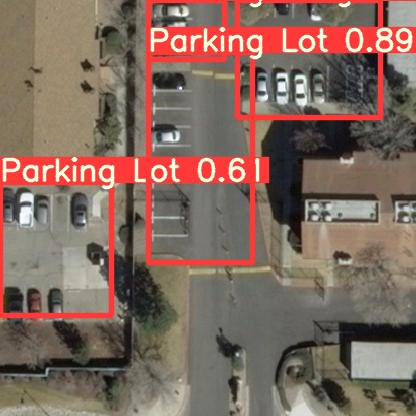

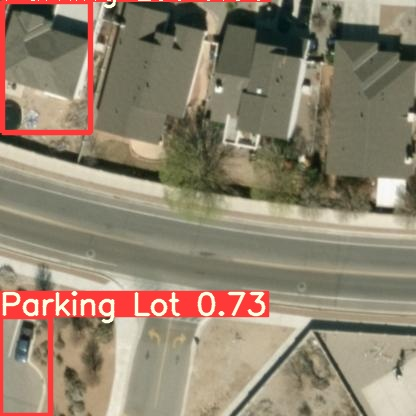

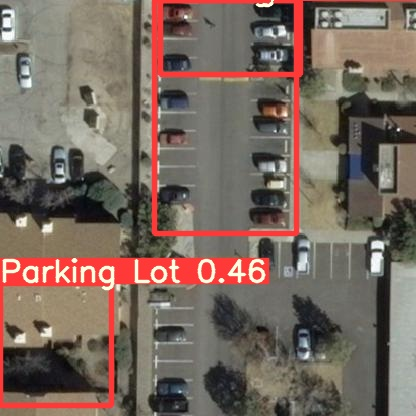

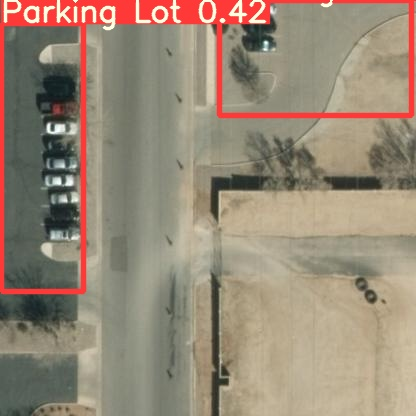

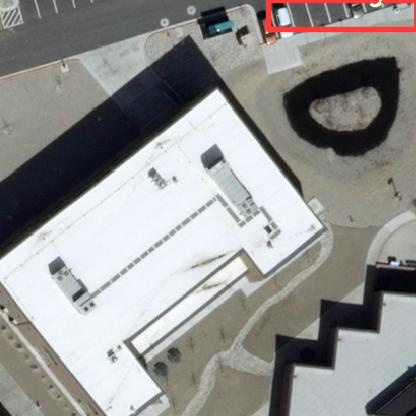

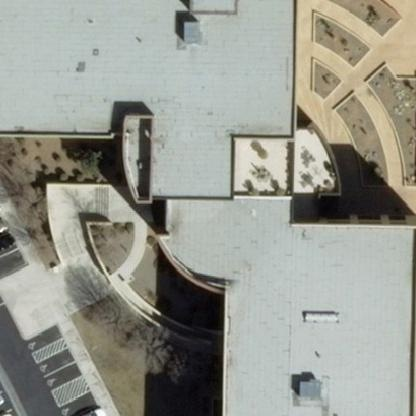

In [ ]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp3/*.jpg'):
    display(Image(filename=imageName))
    print("\n")

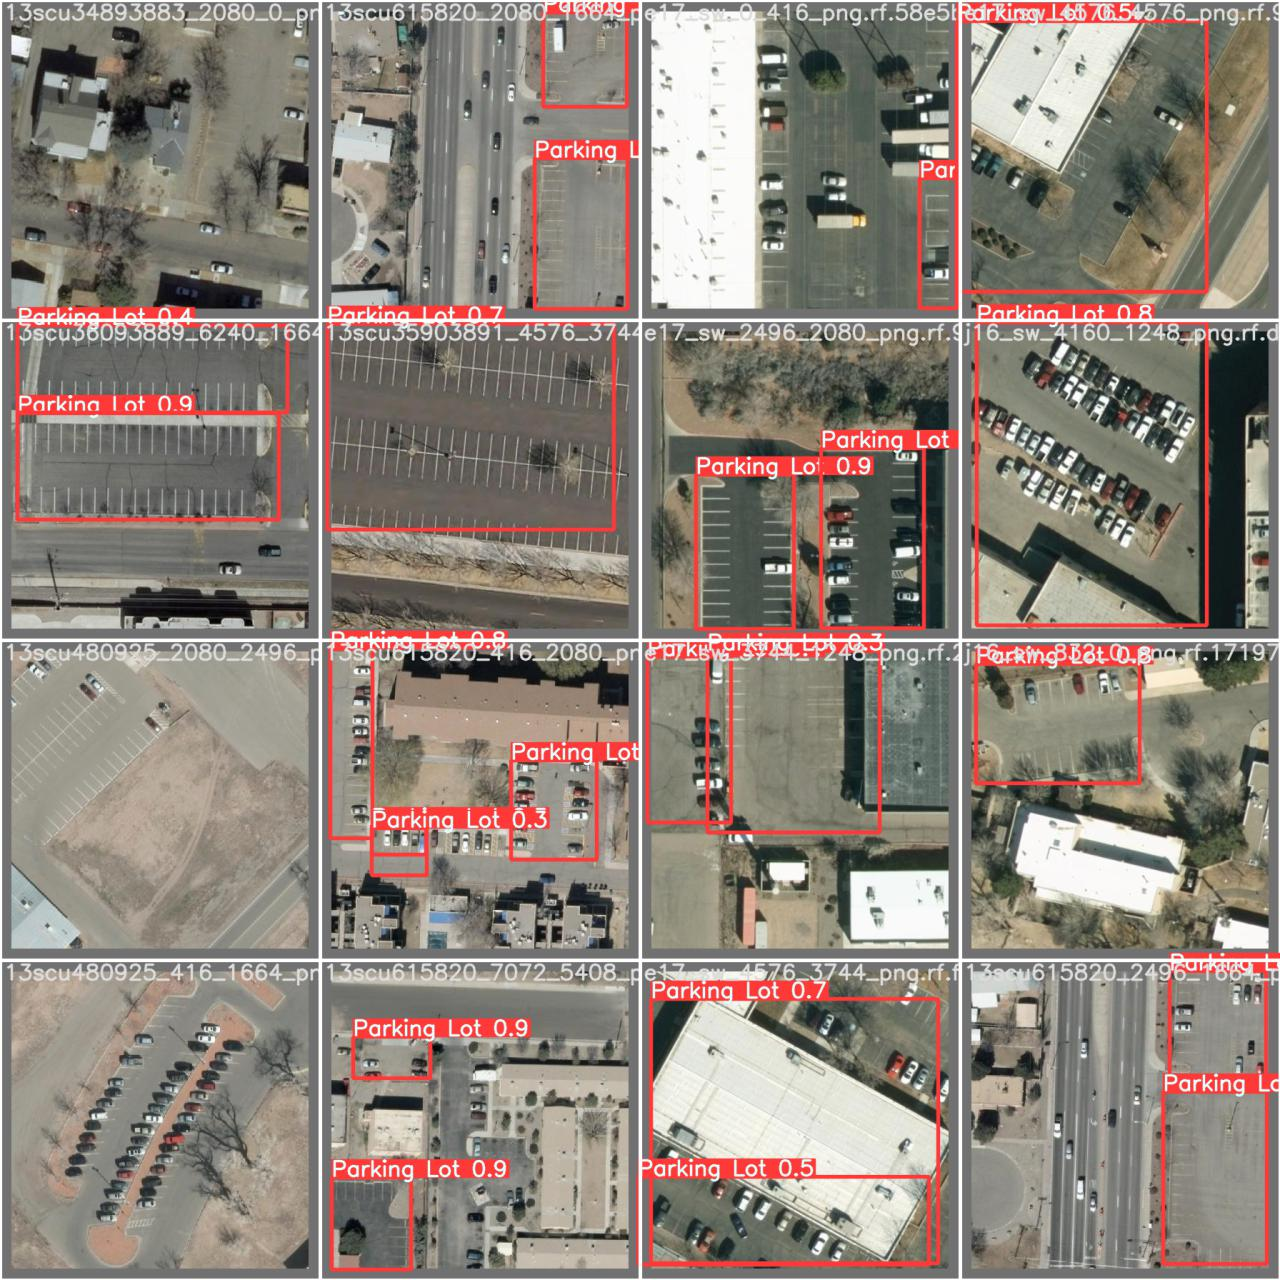

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5s_results3/test_batch0_pred.jpg', width=900)

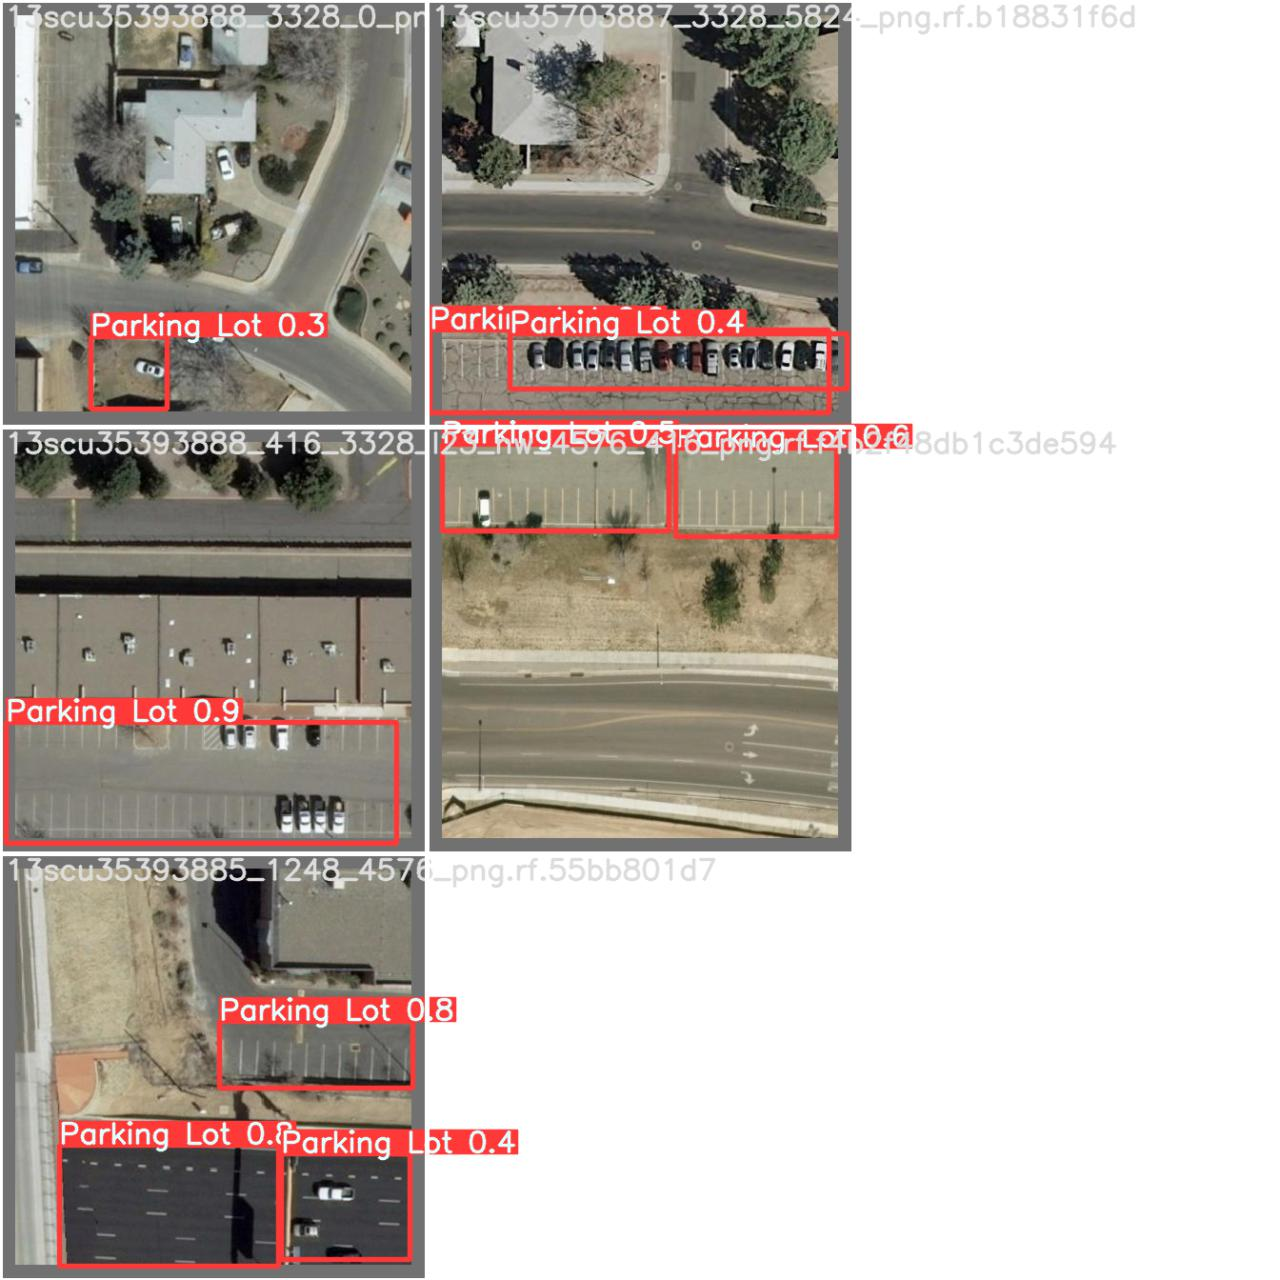

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5s_results3/test_batch1_pred.jpg', width=900)

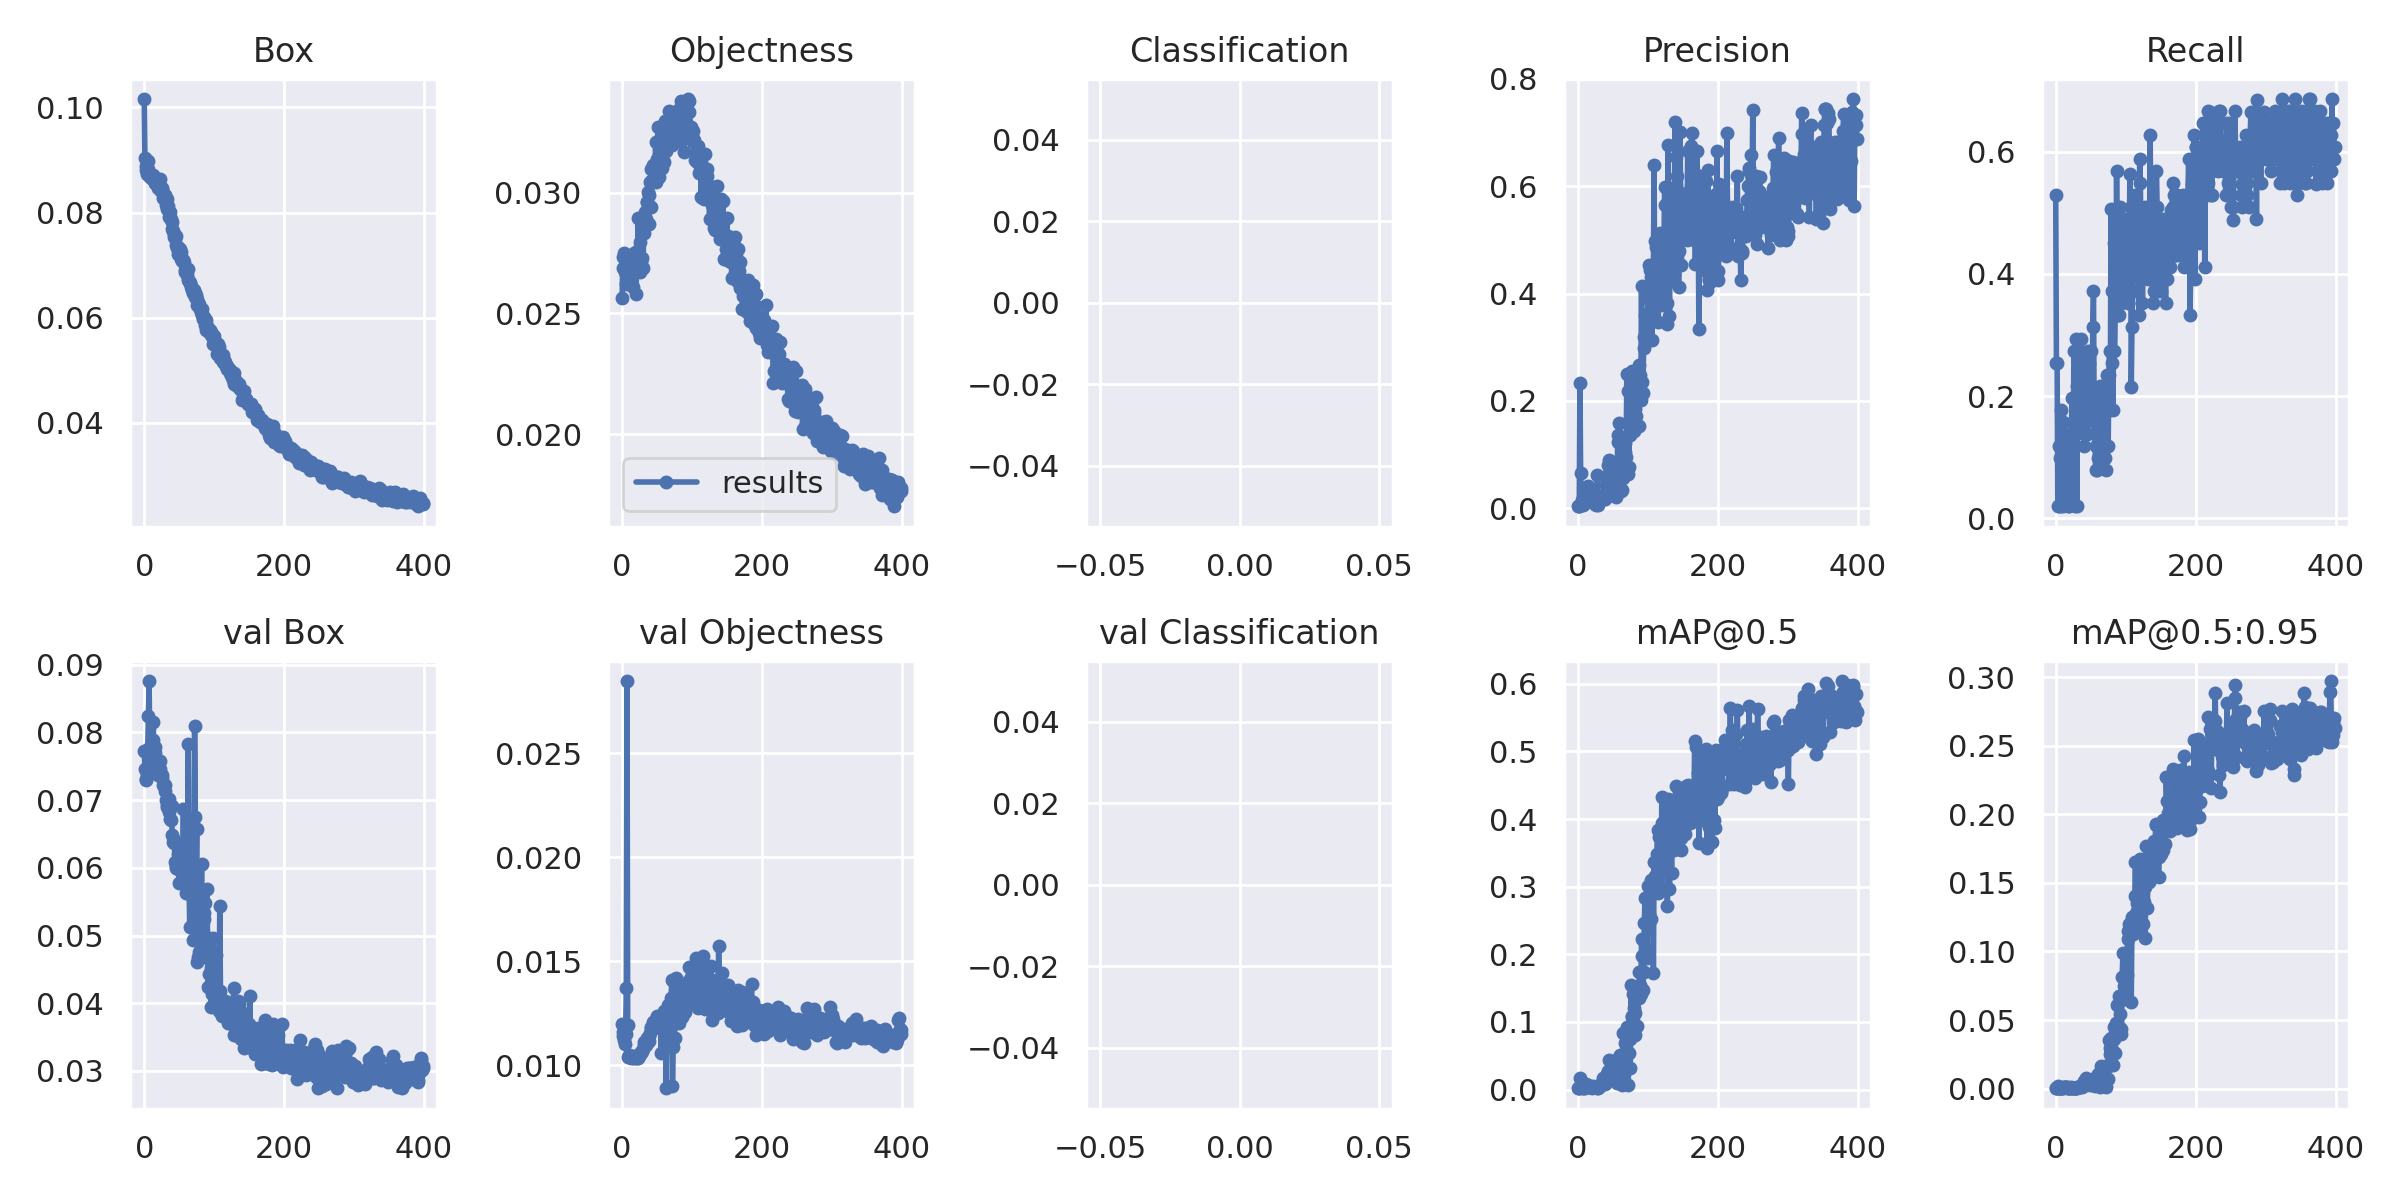

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5s_results3/results.png', width=900)

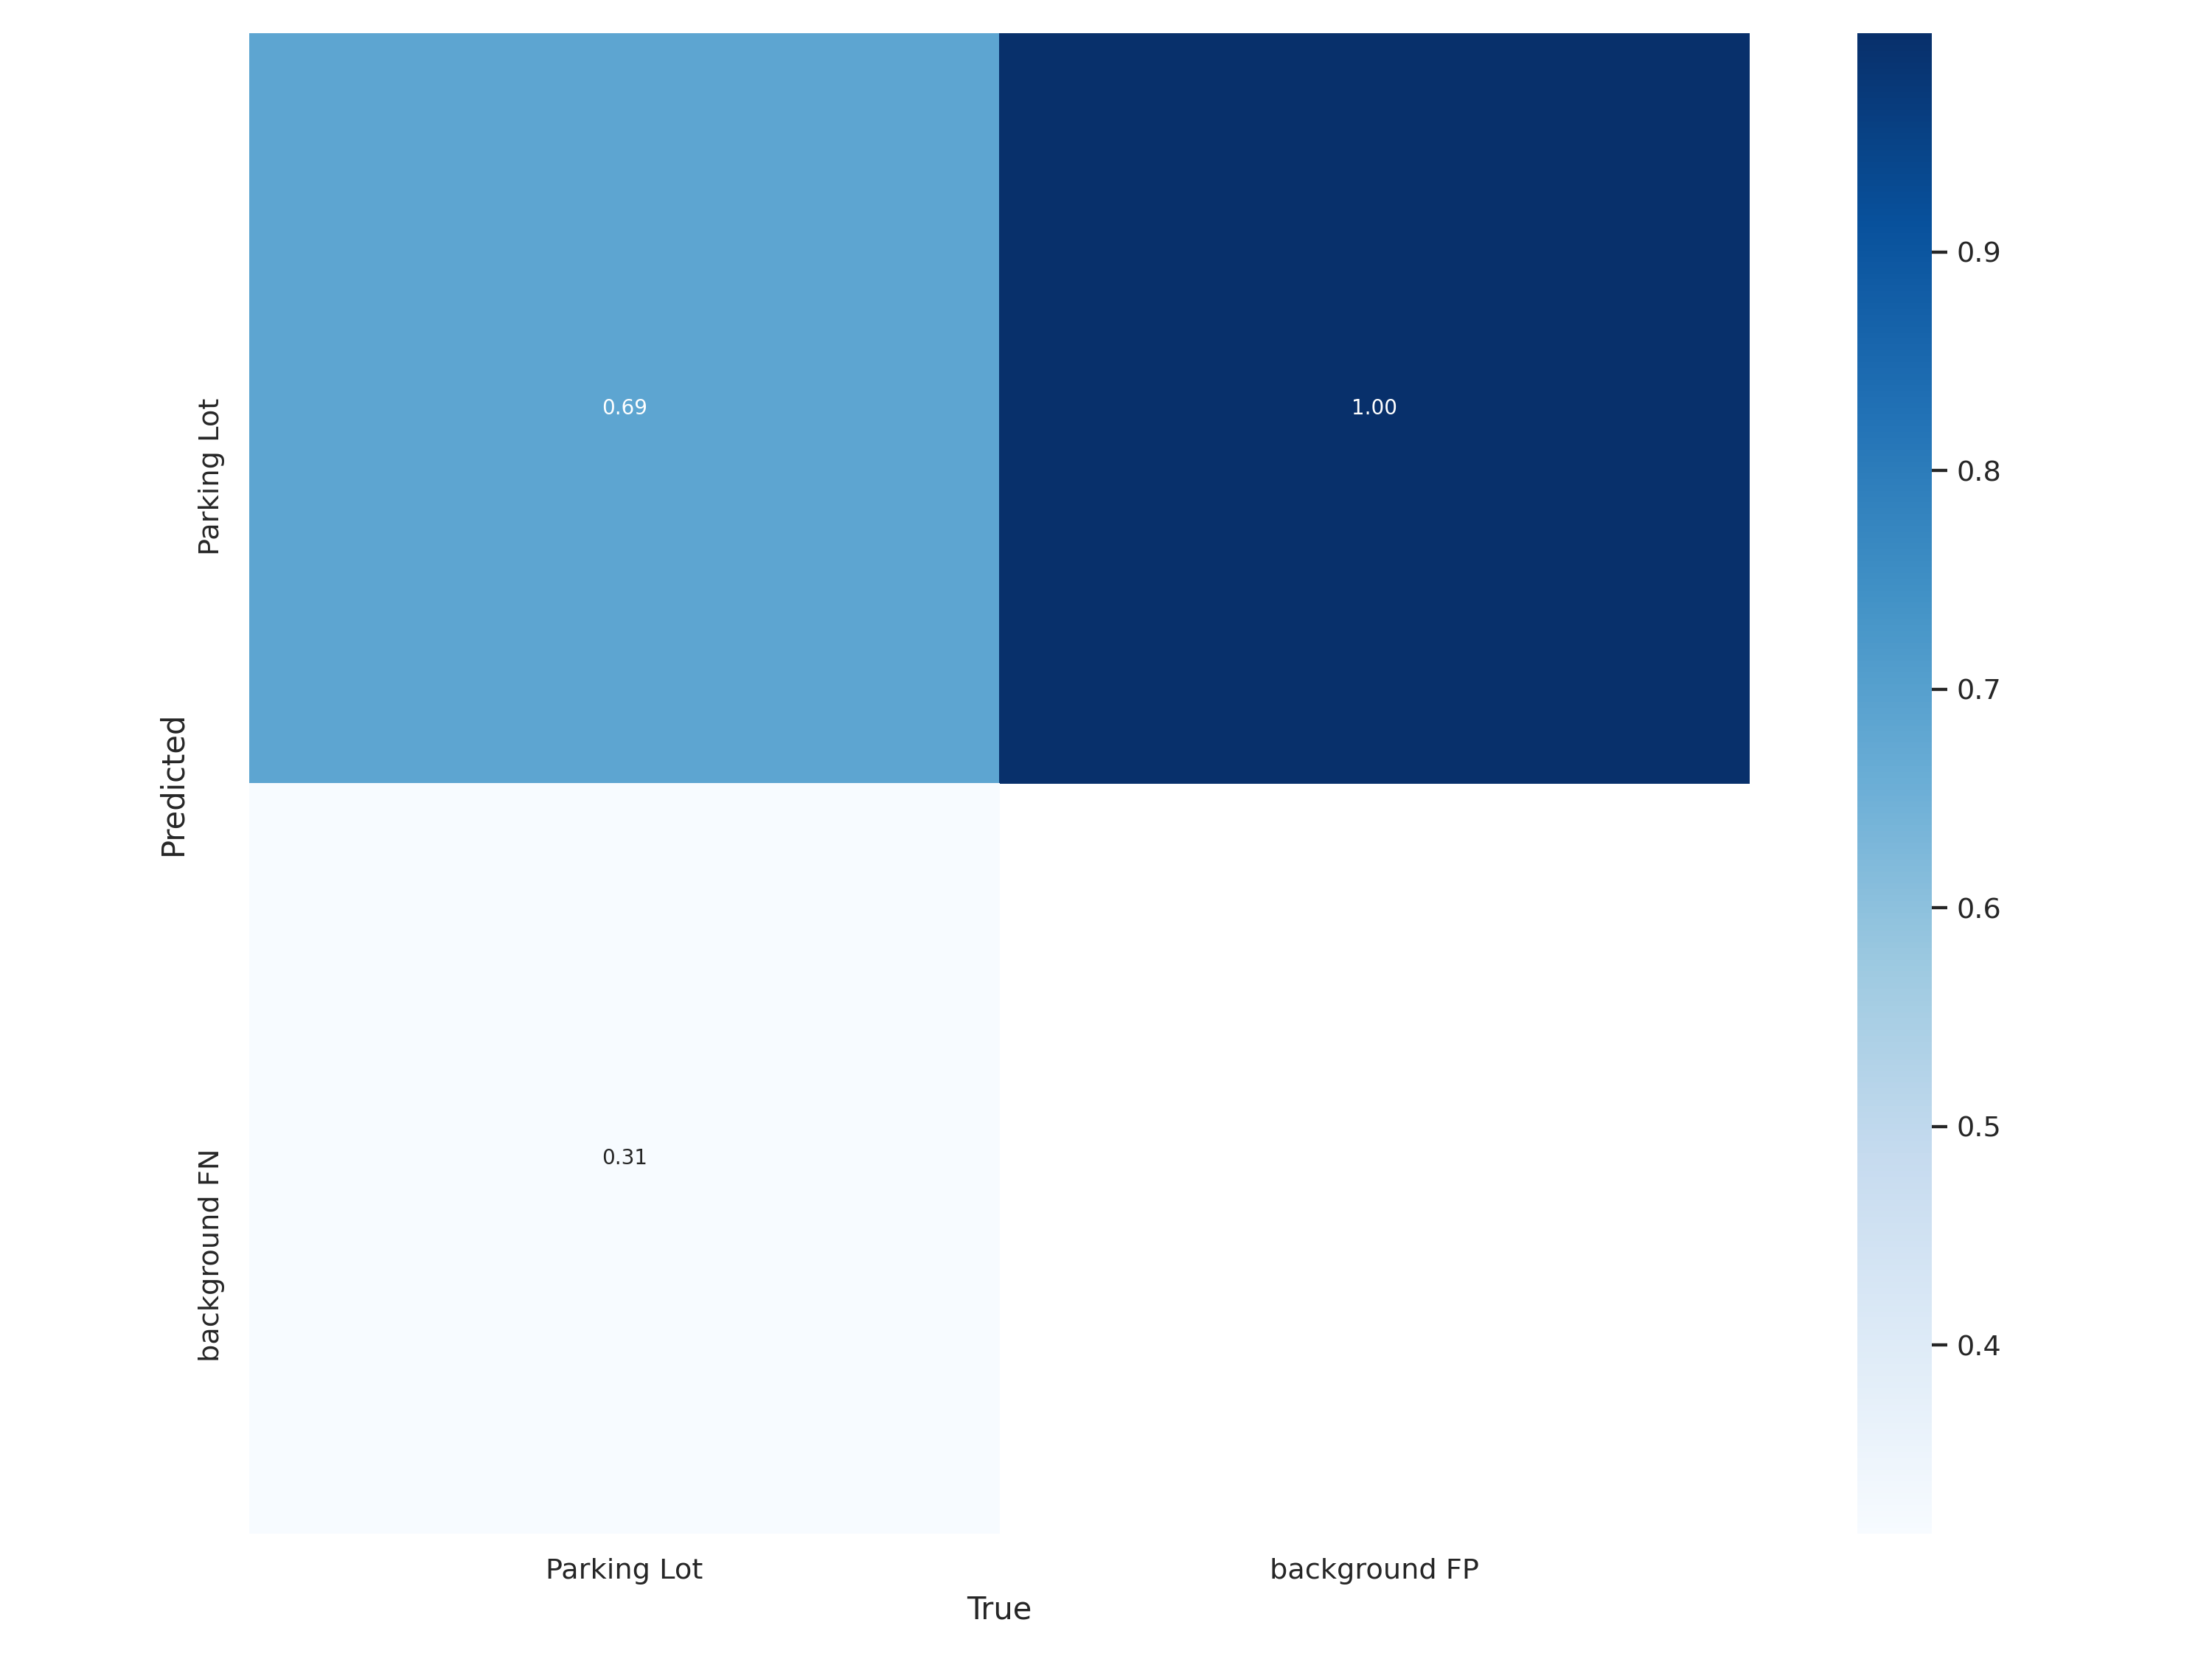

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5s_results3/confusion_matrix.png', width=900)

In [ ]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results3/weights/best.pt --img 416 --conf 0.3 --source ./test/unseen_images

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.3, device='', exist_ok=False, half=False, hide_conf=False, hide_labels=False, imgsz=416, iou_thres=0.45, line_thickness=3, max_det=1000, name='exp', nosave=False, project='runs/detect', save_conf=False, save_crop=False, save_txt=False, source='./test/unseen_images', update=False, view_img=False, weights=['runs/train/yolov5s_results3/weights/best.pt'])
YOLOv5 🚀 v5.0-184-g3133607 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients, 16.8 GFLOPs
image 1/88 /content/yolov5/test/unseen_images/13scu35303886_2912_0.png: 416x416 1 Parking Lot, Done. (0.011s)
image 2/88 /content/yolov5/test/unseen_images/13scu35303886_2912_1248.png: 416x416 1 Parking Lot, Done. (0.010s)
image 3/88 /content/yolov5/test/unseen_images/13scu35303886_2912_1664.png: 416x416 1 Parking Lot, Done. (0.010s)
image 4/88 /content/yolov5/test/unseen_images/13scu35303

In [ ]:
import glob
from IPython.display import Image, display
import ipywidgets as widgets

hbox = widgets.HBox(layout=widgets.Layout(width='100%', display="inline-flex", flex_flow="row wrap"))

for imageName in glob.glob('/content/yolov5/runs/detect/exp4/*.png'):
    img_bytes = open(imageName, "rb").read()
    image = widgets.Image(value=img_bytes, width=352, height=352)
    hbox.children+= (image,)

display(hbox)

In [ ]:
# Export weights

%cp /content/yolov5/runs/train/yolov5s_results3/weights/best.pt /content/drive/MyDrive/Weights/Parking-det-weights.pt

In [3]:
%cd /content/yolov5/
!python detect.py --weights /content/drive/MyDrive/Weights/Parking-det-weights.pt --img 416 --conf 0.3 --source /content/drive/MyDrive/Training\ Slices

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.3, device='', exist_ok=False, half=False, hide_conf=False, hide_labels=False, imgsz=416, iou_thres=0.45, line_thickness=3, max_det=1000, name='exp', nosave=False, project='runs/detect', save_conf=False, save_crop=False, save_txt=False, source='/content/drive/MyDrive/Training Slices', update=False, view_img=False, weights=['/content/drive/MyDrive/Weights/Parking-det-weights.pt'])
YOLOv5 🚀 v5.0-188-g239a11c torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients, 16.8 GFLOPs
image 1/1000 /content/drive/MyDrive/Training Slices/13scu34693883_0_4576.png: 416x416 2 Parking Lots, Done. (0.078s)
image 2/1000 /content/drive/MyDrive/Training Slices/13scu34693883_0_4992.png: 416x416 Done. (0.010s)
image 3/1000 /content/drive/MyDrive/Training Slices/13scu34693883_416_4576.png: 416x416 Done. (0.010s)
image 4/1000 /content/drive/MyDrive/Trainin

In [4]:
import glob
from IPython.display import Image, display
import ipywidgets as widgets
from random import shuffle

hbox = widgets.HBox(layout=widgets.Layout(width='100%', display="inline-flex", flex_flow="row wrap"))

det_images = glob.glob('/content/yolov5/runs/detect/exp/*.png')
shuffle(det_images)

for imageName in det_images[:100]:
    img_bytes = open(imageName, "rb").read()
    image = widgets.Image(value=img_bytes, width=352, height=352)
    hbox.children+= (image,)

display(hbox)